In [1]:
import numpy as np
import pandas as pd
import psutil

from collections import defaultdict
import datatable as dt
import lightgbm as lgb
from matplotlib import pyplot as plt
import riiideducation
import random
from sklearn.metrics import roc_auc_score
import gc

_ = np.seterr(divide='ignore', invalid='ignore')

In [2]:
data_types_dict = {
    'timestamp': 'int64',
    'user_id': 'int32', 
    'content_id': 'int16', 
    'content_type_id':'int8', 
    'task_container_id': 'int16',
    #'user_answer': 'int8',
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'

train_df = dt.fread('../input/riiid-test-answer-prediction/train.csv', columns=set(data_types_dict.keys())).to_pandas()

In [3]:
#reading in lecture df
lectures_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/lectures.csv')

In [4]:
lectures_df['type_of'] = lectures_df['type_of'].replace('solving question', 'solving_question')

lectures_df = pd.get_dummies(lectures_df, columns=['part', 'type_of'])

part_lectures_columns = [column for column in lectures_df.columns if column.startswith('part')]

types_of_lectures_columns = [column for column in lectures_df.columns if column.startswith('type_of_')]

In [5]:
train_lectures = train_df[train_df.content_type_id == True].merge(lectures_df, left_on='content_id', right_on='lecture_id', how='left')

In [6]:
user_lecture_stats_part = train_lectures.groupby('user_id',as_index = False)[part_lectures_columns + types_of_lectures_columns].sum()

In [7]:
lecturedata_types_dict = {   
    'user_id': 'int32', 
    'part_1': 'int8',
    'part_2': 'int8',
    'part_3': 'int8',
    'part_4': 'int8',
    'part_5': 'int8',
    'part_6': 'int8',
    'part_7': 'int8',
    'type_of_concept': 'int8',
    'type_of_intention': 'int8',
    'type_of_solving_question': 'int8',
    'type_of_starter': 'int8'
}
user_lecture_stats_part = user_lecture_stats_part.astype(lecturedata_types_dict)

In [8]:
for column in user_lecture_stats_part.columns:
    #bool_column = column + '_boolean'
    if(column !='user_id'):
        user_lecture_stats_part[column] = (user_lecture_stats_part[column] > 0).astype('int8')

In [9]:
del(train_lectures)

In [10]:
cum = train_df.groupby('user_id')['content_type_id'].agg(['cumsum', 'cumcount'])
train_df['user_lecture_cumsum'] = cum['cumsum'] 
train_df['user_lecture_lv'] = cum['cumsum'] / cum['cumcount']


train_df.user_lecture_lv=train_df.user_lecture_lv.astype('float16')
train_df.user_lecture_cumsum=train_df.user_lecture_cumsum.astype('int8')
user_lecture_agg = train_df.groupby('user_id')['content_type_id'].agg(['sum', 'count'])

In [11]:
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df = train_df.astype(data_types_dict)
train_df = train_df[train_df[target] != -1].reset_index(drop=True)#−１（lecture）をdropする
prior_question_elapsed_time_mean=train_df['prior_question_elapsed_time'].mean()
train_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)#平均値で埋める,inplace=Trueで元データに反映


In [12]:
max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max']).reset_index()
#max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max'])
max_timestamp_u.columns = ['user_id', 'max_time_stamp']

In [13]:
train_df['lagtime'] = train_df.groupby('user_id')['timestamp'].shift()#user_idごとにラグタイムを計算
train_df['lagtime']=train_df['timestamp']-train_df['lagtime']
train_df['lagtime'].fillna(0, inplace=True)
train_df.lagtime=train_df.lagtime.astype('int32')
#train_df.drop(columns=['timestamp'], inplace=True)

In [14]:
lagtime_agg = train_df.groupby('user_id')['lagtime'].agg(['mean'])
train_df['lagtime_mean'] = train_df['user_id'].map(lagtime_agg['mean'])#各user_idに対して、ラグタイムの平均値を入れる
train_df.lagtime_mean=train_df.lagtime_mean.astype('int32')

In [15]:
user_prior_question_elapsed_time = train_df[['user_id','prior_question_elapsed_time']].groupby(['user_id']).tail(1)
#max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max'])
user_prior_question_elapsed_time.columns = ['user_id', 'prior_question_elapsed_time']

In [16]:
train_df['delta_prior_question_elapsed_time'] = train_df.groupby('user_id')['prior_question_elapsed_time'].shift()
train_df['delta_prior_question_elapsed_time']=train_df['prior_question_elapsed_time']-train_df['delta_prior_question_elapsed_time']
train_df['delta_prior_question_elapsed_time'].fillna(0, inplace=True)
train_df.delta_prior_question_elapsed_time=train_df.delta_prior_question_elapsed_time.astype('int32')

In [17]:
train_df['timestamp']=train_df['timestamp']/(1000*3600)
train_df.timestamp=train_df.timestamp.astype('int16')

In [18]:
train_df['lag'] = train_df.groupby('user_id')[target].shift()

cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
train_df['user_correct_cumsum'] = cum['cumsum']
train_df['user_correct_cumcount'] = cum['cumcount']
train_df.drop(columns=['lag'], inplace=True)

# train_df['user_correctness'].fillna(1, inplace=True)
train_df['user_correct_cumsum'].fillna(0, inplace=True)
#train_df['user_correct_cumcount'].fillna(0, inplace=True)
train_df.user_correctness=train_df.user_correctness.astype('float16')
train_df.user_correct_cumcount=train_df.user_correct_cumcount.astype('int16')
train_df.user_correct_cumsum=train_df.user_correct_cumsum.astype('int16')

In [19]:
train_df.prior_question_had_explanation=train_df.prior_question_had_explanation.astype('int8')
train_df['lag'] = train_df.groupby('user_id')['prior_question_had_explanation'].shift()

In [20]:
cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
train_df['explanation_mean'] = cum['cumsum'] / cum['cumcount']
train_df['explanation_cumsum'] = cum['cumsum'] 
train_df.drop(columns=['lag'], inplace=True)

train_df['explanation_mean'].fillna(0, inplace=True)
train_df['explanation_cumsum'].fillna(0, inplace=True)
train_df.explanation_mean=train_df.explanation_mean.astype('float16')
train_df.explanation_cumsum=train_df.explanation_cumsum.astype('int16')

In [21]:
del cum
gc.collect()

126

In [22]:
train_df["attempt_no"] = 1
train_df.attempt_no=train_df.attempt_no.astype('int8')
train_df["attempt_no"] = train_df[["user_id","content_id",'attempt_no']].groupby(["user_id","content_id"])["attempt_no"].cumsum()

In [23]:
explanation_agg = train_df.groupby('user_id')['prior_question_had_explanation'].agg(['sum', 'count'])
#train_df.drop(columns=['prior_question_had_explanation'], inplace=True)

user_agg = train_df.groupby('user_id')[target].agg(['sum', 'count'])
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count','var'])
task_container_agg = train_df.groupby('task_container_id')[target].agg(['sum', 'count','var'])
#prior_question_elapsed_time_agg = train_df.groupby('user_id')['prior_question_elapsed_time'].agg(['sum', 'count'])

attempt_no_agg=train_df.groupby(["user_id","content_id"])["attempt_no"].agg(['sum'])
#attempt_series = train_df[['user_id', 'content_id','attempt_no']].groupby(['user_id','content_id'])['attempt_no'].max()

explanation_agg=explanation_agg.astype('int16')
user_agg=user_agg.astype('int16')
content_agg=content_agg.astype('float32')
task_container_agg=task_container_agg.astype('float32')
attempt_no_agg=attempt_no_agg.astype('int8')

In [24]:
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')
train_df['content_sum'] = train_df['content_id'].map(content_agg['sum']).astype('int32')
train_df['content_correctness'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count'])
train_df.content_correctness=train_df.content_correctness.astype('float16')
train_df['task_container_sum'] = train_df['task_container_id'].map(task_container_agg['sum']).astype('int32')
train_df['task_container_std'] = train_df['task_container_id'].map(task_container_agg['var']).astype('float16')
train_df['task_container_correctness'] = train_df['task_container_id'].map(task_container_agg['sum'] / task_container_agg['count'])
train_df.task_container_correctness=train_df.task_container_correctness.astype('float16')

In [25]:
questions_df = pd.read_csv(
    '../input/riiid-test-answer-prediction/questions.csv', 
    usecols=[0, 1,3,4],
    dtype={'question_id': 'int16','bundle_id': 'int16', 'part': 'int8','tags': 'str'}
)
questions_df['part_bundle_id']=questions_df['part']*100000+questions_df['bundle_id']
questions_df.part_bundle_id=questions_df.part_bundle_id.astype('int32')
tag = questions_df["tags"].str.split(" ", n = 10, expand = True)
tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']
#

tag.fillna(0, inplace=True)
tag = tag.astype('int16')
questions_df =  pd.concat([questions_df,tag],axis=1).drop(['tags'],axis=1)

In [26]:
questions_df.rename(columns={'question_id':'content_id'}, inplace=True)

In [27]:
questions_df['content_correctness'] = questions_df['content_id'].map(content_agg['sum'] / content_agg['count'])
questions_df.content_correctness=questions_df.content_correctness.astype('float16')
questions_df['content_correctness_std'] = questions_df['content_id'].map(content_agg['var'])
questions_df.content_correctness_std=questions_df.content_correctness_std.astype('float16')

In [28]:
part_agg = questions_df.groupby('part')['content_correctness'].agg(['mean', 'var'])
questions_df['part_correctness_mean'] = questions_df['part'].map(part_agg['mean'])
questions_df['part_correctness_std'] = questions_df['part'].map(part_agg['var'])
questions_df.part_correctness_mean=questions_df.part_correctness_mean.astype('float16')
questions_df.part_correctness_std=questions_df.part_correctness_std.astype('float16')

In [29]:
bundle_agg = questions_df.groupby('bundle_id')['content_correctness'].agg(['mean'])
questions_df['bundle_correctness'] = questions_df['bundle_id'].map(bundle_agg['mean'])
questions_df.bundle_correctness=questions_df.bundle_correctness.astype('float16')

In [30]:
tags1_agg = questions_df.groupby('tags1')['content_correctness'].agg(['mean', 'var'])
questions_df['tags1_correctness_mean'] = questions_df['tags1'].map(tags1_agg['mean'])
questions_df['tags1_correctness_std'] = questions_df['tags1'].map(tags1_agg['var'])
questions_df.tags1_correctness_mean=questions_df.tags1_correctness_mean.astype('float16')
questions_df.tags1_correctness_std=questions_df.tags1_correctness_std.astype('float16')

In [31]:
questions_df.drop(columns=['content_correctness'], inplace=True)

In [32]:
del bundle_agg
del part_agg
del tags1_agg
gc.collect()

152

In [33]:
train_df['user_correctness'].fillna( 1, inplace=True)
train_df['attempt_no'].fillna(1, inplace=True)
#
train_df.fillna(0, inplace=True)

# train

In [34]:
features = [
#   'user_id',
#HDKIM    'timestamp',
    'lagtime',
    'lagtime_mean',
   # 'content_id',
   # 'task_container_id',
    'user_lecture_cumsum', # X
    'user_lecture_lv',
    'prior_question_elapsed_time',
    'delta_prior_question_elapsed_time',
    'user_correctness',
    'user_correct_cumcount', #X
    'user_correct_cumsum', #X
    'content_correctness',
   # 'content_correctness_std',
    'content_count',
    'content_sum', #X
    'task_container_correctness',
   # 'task_container_std',
   # 'task_container_sum',
    'bundle_correctness',
    'attempt_no',
    'part',
    'part_correctness_mean',
   # 'part_correctness_std',
    'tags1',
    'tags1_correctness_mean',
  #  'tags1_correctness_std',
#HDKIM    'tags2',
#HDKIM    'tags3',
#HDKIM    'tags4',
#HDKIM    'tags5',
#HDKIM    'tags6',
    'bundle_id',
  #  'part_bundle_id',
    'explanation_mean', 
    'explanation_cumsum',
    'prior_question_had_explanation',
#     'part_1',
#     'part_2',
#     'part_3',
#     'part_4',
#     'part_5',
#     'part_6',
#     'part_7',
#     'type_of_concept',
#     'type_of_intention',
#     'type_of_solving_question',
#     'type_of_starter'
]
categorical_columns= [
#   'user_id',
  #  'content_id',
  # 'task_container_id',
    'part',        
    'tags1',
#HDKIM    'tags2',
#HDKIM    'tags3',
#HDKIM    'tags4',
#HDKIM    'tags5',
#HDKIM    'tags6',
    'bundle_id',
   # 'part_bundle_id',
    'prior_question_had_explanation',
#     'part_1',
#     'part_2',
#     'part_3',
#     'part_4',
#     'part_5',
#     'part_6',
#     'part_7',
#     'type_of_concept',
#     'type_of_intention',
#     'type_of_solving_question',
#     'type_of_starter'
]

In [35]:
flag_lgbm=True
clfs = list()

trains=list()
valids=list()
num=1
for i in range(0,num):
  
    #train_df=train_df.reset_index(drop=True)
    train_df_clf=train_df.sample(n=10000*1000)
    print('sample end')
    #train_df.drop(train_df_clf.index, inplace=True)
    #print('train_df drop end')
    
   
    del train_df
    
    users=train_df_clf['user_id'].drop_duplicates()#去重
    
    users=users.sample(frac=0.025)
    users_df=pd.DataFrame()
    users_df['user_id']=users.values
  
  
    valid_df_newuser = pd.merge(train_df_clf, users_df, on=['user_id'], how='inner',right_index=True)
    del users_df
    del users
    gc.collect()
    #
    train_df_clf.drop(valid_df_newuser.index, inplace=True)
   
    #-----------
    #train_df_clf=train_df_clf.sample(frac=0.2)
    #train_df_clf.drop(valid_df_newuser.index, inplace=True)
    train_df_clf = pd.merge(train_df_clf, questions_df, on='content_id', how='left',right_index=True)#
    valid_df_newuser = pd.merge(valid_df_newuser, questions_df, on='content_id', how='left',right_index=True)#
    
#     train_df_clf = pd.merge(train_df_clf, user_lecture_stats_part, on='user_id', how="left",right_index=True)
#     valid_df_newuser = pd.merge(valid_df_newuser, user_lecture_stats_part, on='user_id', how="left",right_index=True)

    valid_df=train_df_clf.sample(frac=0.09)
    train_df_clf.drop(valid_df.index, inplace=True)
   
    valid_df = valid_df.append(valid_df_newuser)
    del valid_df_newuser
    gc.collect()
    #

    trains.append(train_df_clf)
    valids.append(valid_df)
    print('valid_df length：',len(valid_df))
    #train_df=train_df.reset_index(drop=True)

sample end
valid_df length： 1136056


In [36]:
#del train_df
del train_df_clf
del valid_df
gc.collect()

20

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bundle_id', 'part', 'prior_question_had_explanation', 'tags1']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.772273	valid_1's auc: 0.766537
[100]	training's auc: 0.781174	valid_1's auc: 0.770325
[150]	training's auc: 0.787172	valid_1's auc: 0.771548
[200]	training's auc: 0.791664	valid_1's auc: 0.771949
[250]	training's auc: 0.795147	valid_1's auc: 0.772051
[300]	training's auc: 0.797529	valid_1's auc: 0.772125
[350]	training's auc: 0.799271	valid_1's auc: 0.772189
[400]	training's auc: 0.800619	valid_1's auc: 0.772147
[450]	training's auc: 0.80189	valid_1's auc: 0.772076
[500]	training's auc: 0.802959	valid_1's auc: 0.772042
Early stopping, best iteration is:
[336]	training's auc: 0.798755	valid_1's auc: 0.772216


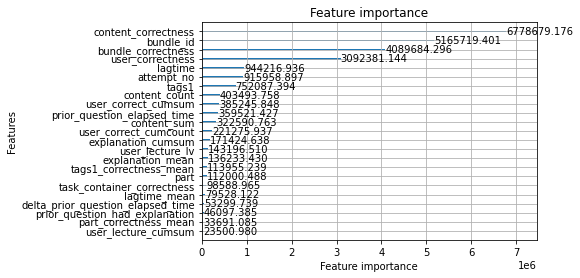

In [37]:
params = {
'num_leaves': 350,
'max_bin':700,
'min_child_weight': 0.03454472573214212,
'feature_fraction': 0.58,
'bagging_fraction': 0.58,
#'min_data_in_leaf': 106,
'objective': 'binary',
'max_depth': -1,
'learning_rate': 0.05,
"boosting_type": "gbdt",
"bagging_seed": 11,
"metric": 'auc',
"verbosity": -1,
'reg_alpha': 0.3899927210061127,
'reg_lambda': 0.6485237330340494,
'random_state': 47
}




for i in range(0,num):

#     
    tr_data = lgb.Dataset(trains[i][features], label=trains[i][target])
    va_data = lgb.Dataset(valids[i][features], label=valids[i][target])
    
#     del train_df_clf
#     del valid_df
#     gc.collect()

    gc.collect()

    model = lgb.train(
        params, 
        tr_data,
#         train_df[features],
#         train_df[target],
        num_boost_round=5000,
        #valid_sets=[(train_df[features],train_df[target]), (valid_df[features],valid_df[target])], 
        valid_sets=[tr_data, va_data],
        early_stopping_rounds=200,
        feature_name=features,
        categorical_feature=categorical_columns,
        verbose_eval=50
    )
    clfs.append(model)
    #print('auc:', roc_auc_score(valid_df[target], model.predict(valid_df[features])))
    #model.save_model(f'model.txt')
    lgb.plot_importance(model, importance_type='gain')
    plt.show()

    del tr_data
    del va_data
    gc.collect()
#    
# del trains
# del valids
# gc.collect()

In [38]:
user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))

del user_agg
del content_agg
gc.collect()

task_container_sum_dict = task_container_agg['sum'].astype('int32').to_dict(defaultdict(int))
task_container_count_dict = task_container_agg['count'].astype('int32').to_dict(defaultdict(int))
task_container_std_dict = task_container_agg['var'].astype('float16').to_dict(defaultdict(int))

explanation_sum_dict = explanation_agg['sum'].astype('int16').to_dict(defaultdict(int))
explanation_count_dict = explanation_agg['count'].astype('int16').to_dict(defaultdict(int))
del task_container_agg
del explanation_agg
gc.collect()


0

In [39]:
user_lecture_sum_dict = user_lecture_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_lecture_count_dict = user_lecture_agg['count'].astype('int16').to_dict(defaultdict(int))

lagtime_mean_dict = lagtime_agg['mean'].astype('int32').to_dict(defaultdict(int))
#del prior_question_elapsed_time_agg
del user_lecture_agg
del lagtime_agg
gc.collect()

20

In [40]:
attempt_no_agg=attempt_no_agg[attempt_no_agg['sum'] >1]
attempt_no_sum_dict = attempt_no_agg['sum'].to_dict(defaultdict(int))

del attempt_no_agg
gc.collect()

0

In [41]:
max_timestamp_u_dict=max_timestamp_u.set_index('user_id').to_dict()
user_prior_question_elapsed_time_dict=user_prior_question_elapsed_time.set_index('user_id').to_dict()
#del question_elapsed_time_agg
del max_timestamp_u
del user_prior_question_elapsed_time
gc.collect()

20

In [42]:
def get_max_attempt(user_id,content_id):
    k = (user_id,content_id)

    if k in attempt_no_sum_dict.keys():
        attempt_no_sum_dict[k]+=1
        return attempt_no_sum_dict[k]

    attempt_no_sum_dict[k] = 1
    return attempt_no_sum_dict[k]

In [43]:
# model = lgb.Booster(model_file='../input/riiid-lgbm-starter/model.txt')
env = riiideducation.make_env()

In [44]:
iter_test = env.iter_test()
prior_test_df = None

In [45]:
%%time

for (test_df, sample_prediction_df) in iter_test:    
    if prior_test_df is not None:
        prior_test_df[target] = eval(test_df['prior_group_answers_correct'].iloc[0])
        prior_test_df = prior_test_df[prior_test_df[target] != -1].reset_index(drop=True)       
        prior_test_df['prior_question_had_explanation'].fillna(False, inplace=True)       
        prior_test_df.prior_question_had_explanation=prior_test_df.prior_question_had_explanation.astype('int8')
    
        user_ids = prior_test_df['user_id'].values
        content_ids = prior_test_df['content_id'].values
        task_container_ids = prior_test_df['task_container_id'].values
        prior_question_had_explanations = prior_test_df['prior_question_had_explanation'].values
        targets = prior_test_df[target].values
       
        
        
        for user_id, content_id,prior_question_had_explanation,task_container_id,answered_correctly in zip(user_ids, content_ids, prior_question_had_explanations,task_container_ids,targets):
            user_sum_dict[user_id] += answered_correctly
            user_count_dict[user_id] += 1         
            explanation_sum_dict[user_id] += prior_question_had_explanation
            explanation_count_dict[user_id] += 1
            

    prior_test_df = test_df.copy()
    lecture_test_df = test_df[test_df['content_type_id'] == 1].reset_index(drop=True)
    for i, (user_id,content_type_id, content_id) in enumerate(zip(lecture_test_df['user_id'].values,lecture_test_df['content_type_id'].values,lecture_test_df['content_id'].values)):
      
        user_lecture_sum_dict[user_id] += content_type_id
        user_lecture_count_dict[user_id] += 1
        #
        if(len(user_lecture_stats_part[user_lecture_stats_part.user_id==user_id])==0):
            user_lecture_stats_part = user_lecture_stats_part.append([{'user_id':user_id}], ignore_index=True)
            user_lecture_stats_part.fillna(0, inplace=True)
            user_lecture_stats_part.loc[user_lecture_stats_part.user_id==user_id,part_lectures_columns + types_of_lectures_columns]+=lectures_df[lectures_df.lecture_id==content_id][part_lectures_columns + types_of_lectures_columns].values
        else:
            user_lecture_stats_part.loc[user_lecture_stats_part.user_id==user_id,part_lectures_columns + types_of_lectures_columns]+=lectures_df[lectures_df.lecture_id==content_id][part_lectures_columns + types_of_lectures_columns].values
  
        
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
   
    test_df['prior_question_had_explanation'].fillna(False, inplace=True)
    test_df.prior_question_had_explanation=test_df.prior_question_had_explanation.astype('int8')
    test_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)
    

    user_lecture_sum = np.zeros(len(test_df), dtype=np.int16)
    user_lecture_count = np.zeros(len(test_df), dtype=np.int16) 
    
    user_sum = np.zeros(len(test_df), dtype=np.int16)
    user_count = np.zeros(len(test_df), dtype=np.int16)
    content_sum = np.zeros(len(test_df), dtype=np.int32)
    content_count = np.zeros(len(test_df), dtype=np.int32)
    task_container_sum = np.zeros(len(test_df), dtype=np.int32)
    task_container_count = np.zeros(len(test_df), dtype=np.int32)
    task_container_std = np.zeros(len(test_df), dtype=np.float16)
    content_task_mean = np.zeros(len(test_df), dtype=np.float16)
    explanation_sum = np.zeros(len(test_df), dtype=np.int32)
    explanation_count = np.zeros(len(test_df), dtype=np.int32)
    delta_prior_question_elapsed_time = np.zeros(len(test_df), dtype=np.int32)

    attempt_no_count = np.zeros(len(test_df), dtype=np.int16)
    lagtime = np.zeros(len(test_df), dtype=np.int32)
    lagtime_mean = np.zeros(len(test_df), dtype=np.int32)
   
    
    for i, (user_id,prior_question_had_explanation,content_type_id,prior_question_elapsed_time,timestamp, content_id,task_container_id) in enumerate(zip(test_df['user_id'].values,test_df['prior_question_had_explanation'].values,test_df['content_type_id'].values,test_df['prior_question_elapsed_time'].values,test_df['timestamp'].values, test_df['content_id'].values, test_df['task_container_id'].values)):
         
        user_lecture_sum_dict[user_id] += content_type_id
        user_lecture_count_dict[user_id] += 1
        
        user_lecture_sum[i] = user_lecture_sum_dict[user_id]
        user_lecture_count[i] = user_lecture_count_dict[user_id]
        
        user_sum[i] = user_sum_dict[user_id]
        user_count[i] = user_count_dict[user_id]
        content_sum[i] = content_sum_dict[content_id]
        content_count[i] = content_count_dict[content_id]
        task_container_sum[i] = task_container_sum_dict[task_container_id]
        task_container_count[i] = task_container_count_dict[task_container_id]
        task_container_std[i]=task_container_std_dict[task_container_id]
      
        explanation_sum[i] = explanation_sum_dict[user_id]
        explanation_count[i] = explanation_count_dict[user_id]
  
        if user_id in max_timestamp_u_dict['max_time_stamp'].keys():
            lagtime[i]=timestamp-max_timestamp_u_dict['max_time_stamp'][user_id]
            max_timestamp_u_dict['max_time_stamp'][user_id]=timestamp
            lagtime_mean[i]=(lagtime_mean_dict[user_id]+lagtime[i])/2           
        else:
            lagtime[i]=0
            max_timestamp_u_dict['max_time_stamp'].update({user_id:timestamp})
            lagtime_mean_dict.update({user_id:timestamp})
            lagtime_mean[i]=(lagtime_mean_dict[user_id]+lagtime[i])/2
            
        if user_id in user_prior_question_elapsed_time_dict['prior_question_elapsed_time'].keys():            
            delta_prior_question_elapsed_time[i]=prior_question_elapsed_time-user_prior_question_elapsed_time_dict['prior_question_elapsed_time'][user_id]
            user_prior_question_elapsed_time_dict['prior_question_elapsed_time'][user_id]=prior_question_elapsed_time
        else:           
            delta_prior_question_elapsed_time[i]=0    
            user_prior_question_elapsed_time_dict['prior_question_elapsed_time'].update({user_id:prior_question_elapsed_time})
           
        
        
    
    #
    #test_df = pd.merge(test_df, questions_df, on='content_id', how='left',right_index=True)    
    #test_df = pd.concat([test_df.reset_index(drop=True), questions_df.reindex(test_df['content_id'].values).reset_index(drop=True)], axis=1)
    test_df=test_df.merge(questions_df.loc[questions_df.index.isin(test_df['content_id'])],
                  how='left', on='content_id', right_index=True)
    
    #test_df = pd.merge(test_df, user_lecture_stats_part, on=['user_id'], how="left",right_index=True)
    #test_df = pd.concat([test_df.reset_index(drop=True), user_lecture_stats_part.reindex(test_df['user_id'].values).reset_index(drop=True)], axis=1)
#     test_df=test_df.merge(user_lecture_stats_part.loc[user_lecture_stats_part.index.isin(test_df['user_id'])],
#                   how='left', on='user_id', right_index=True)
 
    test_df['user_lecture_lv'] = user_lecture_sum / user_lecture_count
    test_df['user_lecture_cumsum'] = user_lecture_sum
    test_df['user_correctness'] = user_sum / user_count
    test_df['user_correct_cumcount'] =user_count
    test_df['user_correct_cumsum'] =user_sum
    #
    test_df['content_correctness'] = content_sum / content_count
    test_df['content_count'] = content_count
    test_df['content_sum'] = content_sum
    
    test_df['task_container_correctness'] = task_container_sum / task_container_count
    test_df['task_container_sum'] = task_container_sum 
    test_df['task_container_std'] = task_container_std 
    #test_df['content_task_mean'] = content_task_mean 
    
    test_df['explanation_mean'] = explanation_sum / explanation_count
    test_df['explanation_cumsum'] = explanation_sum 
    
    #
    test_df['delta_prior_question_elapsed_time'] = delta_prior_question_elapsed_time 
    
  
 
    test_df["attempt_no"] = test_df[["user_id", "content_id"]].apply(lambda row: get_max_attempt(row["user_id"], row["content_id"]), axis=1)
    test_df["lagtime"]=lagtime
    test_df["lagtime_mean"]=lagtime_mean

    test_df['user_correctness'].fillna( 1, inplace=True)
    test_df['attempt_no'].fillna(1, inplace=True)
    #
    test_df.fillna(0, inplace=True)
    

    test_df['timestamp']=test_df['timestamp']/(1000*3600)
    test_df.timestamp=test_df.timestamp.astype('int16')


    sub_preds = np.zeros(test_df.shape[0])
    for i, model in enumerate(clfs, 1):
        test_preds  = model.predict(test_df[features])
        sub_preds += test_preds
    test_df[target]=sub_preds / len(clfs)
    
#     if(flag_lgbm):
#         test_df[target] = model.predict(test_df[features])
#     else:
#         test_df[target] = model.predict(test_df[features].values)
    env.predict(test_df[['row_id', target]])

CPU times: user 1.25 s, sys: 86.9 ms, total: 1.34 s
Wall time: 681 ms


In [46]:
test_df.columns

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'prior_question_elapsed_time',
       'prior_question_had_explanation', 'prior_group_answers_correct',
       'prior_group_responses', 'bundle_id', 'part', 'part_bundle_id', 'tags1',
       'tags2', 'tags3', 'tags4', 'tags5', 'tags6', 'content_correctness_std',
       'part_correctness_mean', 'part_correctness_std', 'bundle_correctness',
       'tags1_correctness_mean', 'tags1_correctness_std', 'user_lecture_lv',
       'user_lecture_cumsum', 'user_correctness', 'user_correct_cumcount',
       'user_correct_cumsum', 'content_correctness', 'content_count',
       'content_sum', 'task_container_correctness', 'task_container_sum',
       'task_container_std', 'explanation_mean', 'explanation_cumsum',
       'delta_prior_question_elapsed_time', 'attempt_no', 'lagtime',
       'lagtime_mean', 'answered_correctly'],
      dtype='object')

In [47]:
sub = pd.DataFrame()
sub['row_id'] = test_df['row_id']
sub['answered_correctly'] = test_df['answered_correctly']

sub.to_csv('submission.csv', index=False)